# *(Bellec, et. al, 2020)*: eprop for Evidence Accumulation Task

Implementation of the paper:

- Bellec, G., Scherr, F., Subramoney, A., Hajek, E., Salaj, D., Legenstein, R.,
  & Maass, W. (2020). A solution to the learning dilemma for recurrent networks
  of spiking neurons. Nature communications, 11(1), 1-15.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import brainpy as bp
import brainpy.math as bm
from jax.lax import stop_gradient
from matplotlib import patches

In [2]:

bm.set_dt(1.)  # Simulation time step [ms]

# training parameters
n_batch = 128  # batch size

# neuron model and simulation parameters
reg_f = 1.  # regularization coefficient for firing rate
reg_rate = 10  # target firing rate for regularization [Hz]

# Experiment parameters
t_cue_spacing = 150  # distance between two consecutive cues in ms

# Frequencies
input_f0 = 40. / 1000.  # poisson firing rate of input neurons in khz
regularization_f0 = reg_rate / 1000.  # mean target network firing frequency


In [3]:

class EligSNN(bp.dyn.Network):
  def __init__(self, num_in, num_rec, num_out, eprop=True, tau_a=2e3, tau_v=2e1):
    super(EligSNN, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out
    self.eprop = eprop

    # neurons
    self.i = bp.neurons.InputGroup(num_in)
    self.o = bp.neurons.LeakyIntegrator(num_out, tau=20, mode=bp.modes.training)

    n_regular = int(num_rec / 2)
    n_adaptive = num_rec - n_regular
    beta1 = bm.exp(- bm.get_dt() / tau_a)
    beta2 = 1.7 * (1 - beta1) / (1 - bm.exp(-1 / tau_v))
    beta = bm.concatenate([bm.ones(n_regular), bm.ones(n_adaptive) * beta2])
    self.r = bp.neurons.ALIFBellec2020(
      num_rec, V_rest=0., tau_ref=5., V_th=0.6,
      tau_a=tau_a, tau=tau_v, beta=beta,
      V_initializer=bp.init.ZeroInit(),
      a_initializer=bp.init.ZeroInit(),
      mode=bp.modes.training, eprop=eprop
    )

    # synapses
    self.i2r = bp.layers.Dense(num_in, num_rec,
                               W_initializer=bp.init.KaimingNormal(),
                               b_initializer=None)
    self.i2r.W *= tau_v
    self.r2r = bp.layers.Dense(num_rec, num_rec,
                               W_initializer=bp.init.KaimingNormal(),
                               b_initializer=None)
    self.r2r.W *= tau_v
    self.r2o = bp.layers.Dense(num_rec, num_out,
                               W_initializer=bp.init.KaimingNormal(),
                               b_initializer=None)

  def update(self, shared, x):
    self.r.input += self.i2r(shared, x)
    z = self.r.spike if self.eprop else stop_gradient(self.r.spike.value)
    self.r.input += self.r2r(shared, z)
    self.r(shared)
    self.o.input += self.r2o(shared, self.r.spike.value)
    self.o(shared)
    return self.o.V.value


In [4]:

net = EligSNN(num_in=40, num_rec=100, num_out=2, eprop=False)


In [5]:

@bp.tools.numba_jit
def generate_click_task_data(batch_size, seq_len, n_neuron, recall_duration, prob, f0=0.5,
                             n_cues=7, t_cue=100, t_interval=150, n_input_symbols=4):
  n_channel = n_neuron // n_input_symbols

  # assign input spike probabilities
  probs = np.where(np.random.random((batch_size, 1)) < 0.5, prob, 1 - prob)

  # for each example in batch, draw which cues are going to be active (left or right)
  cue_assignments = np.asarray(np.random.random(n_cues) > probs, dtype=np.int_)

  # generate input nums - 0: left, 1: right, 2:recall, 3:background noise
  input_nums = 3 * np.ones((batch_size, seq_len), dtype=np.int_)
  input_nums[:, :n_cues] = cue_assignments
  input_nums[:, -1] = 2

  # generate input spikes
  input_spike_prob = np.zeros((batch_size, seq_len, n_neuron))
  d_silence = t_interval - t_cue
  for b in range(batch_size):
    for k in range(n_cues):
      # input channels only fire when they are selected (left or right)
      c = cue_assignments[b, k]
      # reverse order of cues
      i_seq = d_silence + k * t_interval
      i_neu = c * n_channel
      input_spike_prob[b, i_seq:i_seq + t_cue, i_neu:i_neu + n_channel] = f0
  # recall cue
  input_spike_prob[:, -recall_duration:, 2 * n_channel:3 * n_channel] = f0
  # background noise
  input_spike_prob[:, :, 3 * n_channel:] = f0 / 4.
  input_spikes = input_spike_prob > np.random.rand(*input_spike_prob.shape)

  # generate targets
  target_mask = np.zeros((batch_size, seq_len), dtype=np.bool_)
  target_mask[:, -1] = True
  target_nums = (np.sum(cue_assignments, axis=1) > n_cues / 2).astype(np.int_)
  return input_spikes, input_nums, target_nums, target_mask


In [6]:

def get_data(batch_size, n_in, t_interval, f0):
  # used for obtaining a new randomly generated batch of examples
  def generate_data():
    for _ in range(10):
      seq_len = int(t_interval * 7 + 1200)
      spk_data, _, target_data, _ = generate_click_task_data(
        batch_size=batch_size, seq_len=seq_len, n_neuron=n_in, recall_duration=150,
        prob=0.3, t_cue=100, n_cues=7, t_interval=t_interval, f0=f0, n_input_symbols=4
      )
      yield spk_data, target_data

  return generate_data


In [7]:

def loss_fun(predicts, targets):
  predicts, mon = predicts

  # we only use network output at the end for classification
  output_logits = predicts[:, -t_cue_spacing:]

  # Define the accuracy
  y_predict = bm.argmax(bm.mean(output_logits, axis=1), axis=1)
  accuracy = bm.equal(targets, y_predict).astype(bm.dftype()).mean()

  # loss function
  tiled_targets = bm.tile(bm.expand_dims(targets, 1), (1, t_cue_spacing))
  loss_cls = bm.mean(bp.losses.cross_entropy_loss(output_logits, tiled_targets))

  # Firing rate regularization:
  # For historical reason we often use this regularization,
  # but the other one is easier to implement in an "online" fashion by a single agent.
  av = bm.mean(mon['r.spike'], axis=(0, 1)) / bm.get_dt()
  loss_reg_f = bm.sum(bm.square(av - regularization_f0) * reg_f)

  # Aggregate the losses #
  loss = loss_reg_f + loss_cls
  loss_res = {'loss': loss, 'loss reg': loss_reg_f, 'accuracy': accuracy}
  return loss, loss_res

## Training

In [8]:

# Training
trainer = bp.train.BPTT(
  net, loss_fun,
  loss_has_aux=True,
  optimizer=bp.optimizers.Adam(lr=0.01),
  monitors={'r.spike': net.r.spike},
)
trainer.fit(get_data(n_batch, n_in=net.num_in, t_interval=t_cue_spacing, f0=input_f0),
            num_epoch=40,
            num_report=10)

Train 10 steps, use 10.7197 s, train loss 0.69447, accuracy 0.609375, loss 0.6944664120674133, loss reg 0.0049131689593195915
Train 20 steps, use 7.0137 s, train loss 0.69414, accuracy 0.5859375, loss 0.6941389441490173, loss reg 0.00466389674693346
Train 30 steps, use 6.8111 s, train loss 0.6954, accuracy 0.4921875, loss 0.6954018473625183, loss reg 0.004541081842035055
Train 40 steps, use 6.9719 s, train loss 0.68993, accuracy 0.59375, loss 0.6899335384368896, loss reg 0.004419579170644283
Train 50 steps, use 6.8297 s, train loss 0.73685, accuracy 0.0, loss 0.7368453145027161, loss reg 0.004660312552005053
Train 60 steps, use 6.7019 s, train loss 0.68552, accuracy 0.84375, loss 0.6855180859565735, loss reg 0.004129704553633928
Train 70 steps, use 6.8393 s, train loss 0.64123, accuracy 1.0, loss 0.6412255167961121, loss reg 0.004782373085618019
Train 80 steps, use 6.7781 s, train loss 0.67649, accuracy 0.625, loss 0.6764945983886719, loss reg 0.004046454094350338
Train 90 steps, use 6

## Visualization

  0%|          | 0/2250 [00:00<?, ?it/s]

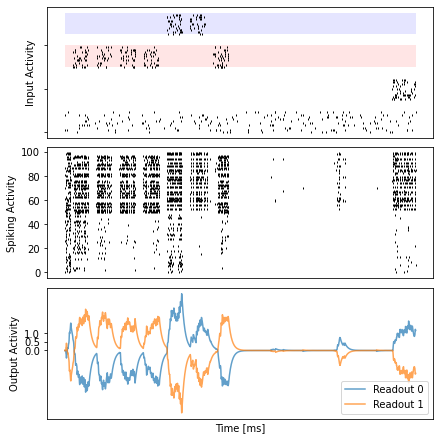

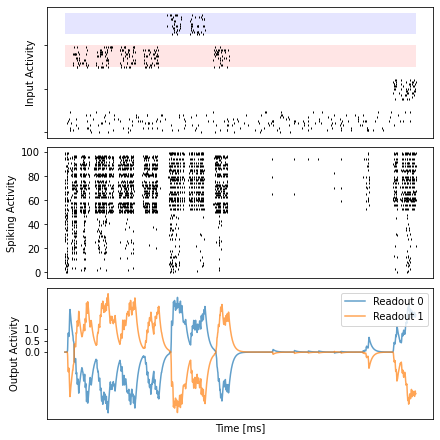

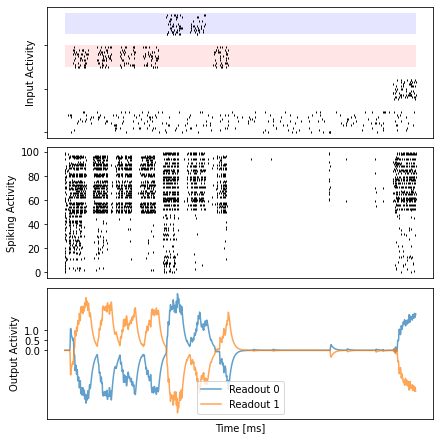

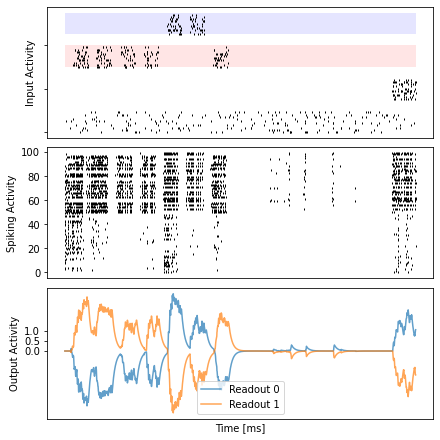

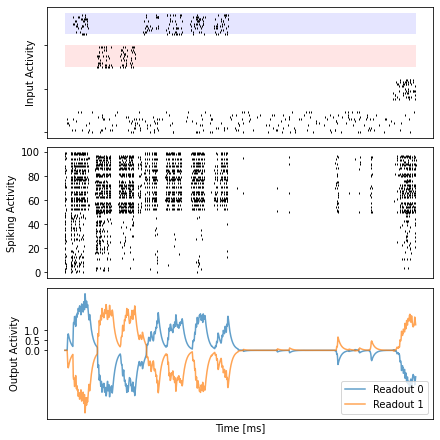

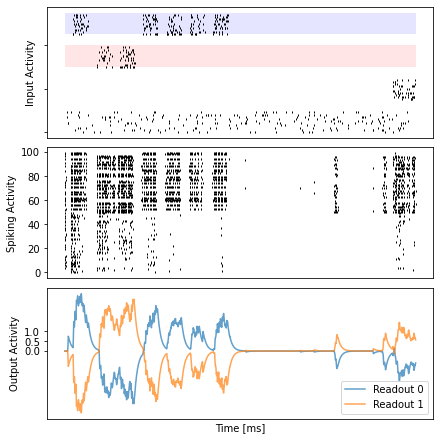

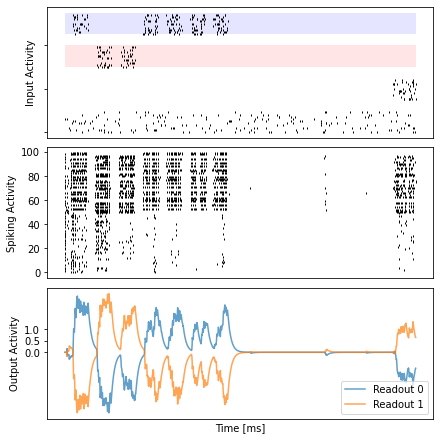

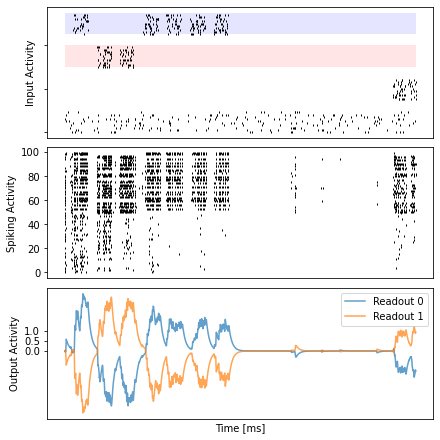

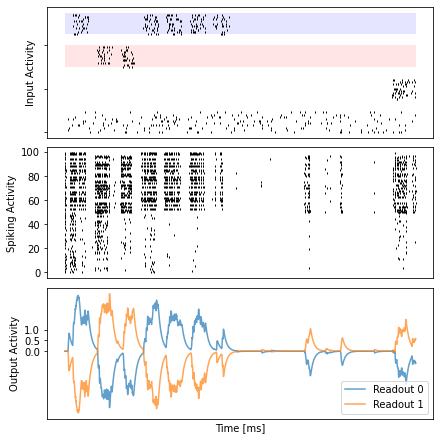

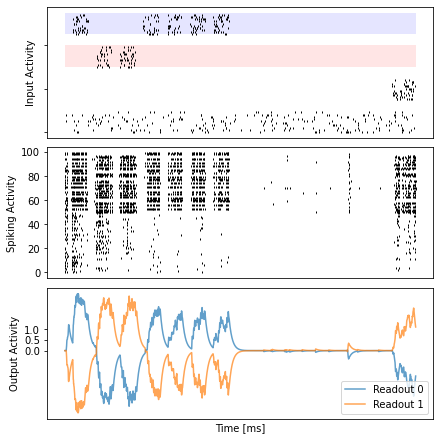

In [9]:

# visualization
dataset, _ = next(get_data(20, n_in=net.num_in, t_interval=t_cue_spacing, f0=input_f0)())
runner = bp.train.DSTrainer(net, monitors={'spike': net.r.spike})
outs = runner.predict(dataset, reset_state=True)

for i in range(10):
  fig, gs = bp.visualize.get_figure(3, 1, 2., 6.)
  ax_inp = fig.add_subplot(gs[0, 0])
  ax_rec = fig.add_subplot(gs[1, 0])
  ax_out = fig.add_subplot(gs[2, 0])

  data = dataset[i]
  # insert empty row
  n_channel = data.shape[1] // 4
  zero_fill = np.zeros((data.shape[0], int(n_channel / 2)))
  data = np.concatenate((data[:, 3 * n_channel:], zero_fill,
                         data[:, 2 * n_channel:3 * n_channel], zero_fill,
                         data[:, :n_channel], zero_fill,
                         data[:, n_channel:2 * n_channel]), axis=1)
  ax_inp.set_yticklabels([])
  ax_inp.add_patch(patches.Rectangle((0, 2 * n_channel + 2 * int(n_channel / 2)),
                                     data.shape[0], n_channel,
                                     facecolor="red", alpha=0.1))
  ax_inp.add_patch(patches.Rectangle((0, 3 * n_channel + 3 * int(n_channel / 2)),
                                     data.shape[0], n_channel,
                                     facecolor="blue", alpha=0.1))
  bp.visualize.raster_plot(runner.mon.ts, data, ax=ax_inp, marker='|')
  ax_inp.set_ylabel('Input Activity')
  ax_inp.set_xticklabels([])
  ax_inp.set_xticks([])

  # spiking activity
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'][i], ax=ax_rec, marker='|')
  ax_rec.set_ylabel('Spiking Activity')
  ax_rec.set_xticklabels([])
  ax_rec.set_xticks([])
  # decision activity
  ax_out.set_yticks([0, 0.5, 1])
  ax_out.set_ylabel('Output Activity')
  ax_out.plot(runner.mon.ts, outs[i, :, 0], label='Readout 0', alpha=0.7)
  ax_out.plot(runner.mon.ts, outs[i, :, 1], label='Readout 1', alpha=0.7)
  ax_out.set_xticklabels([])
  ax_out.set_xticks([])
  ax_out.set_xlabel('Time [ms]')
  plt.legend()
  plt.show()